In [1]:
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np
from skimage.measure import label, regionprops
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cropping

Apply Adaptive Thresholding with Otsu's Method

In [4]:
from skimage import io

# Example loading a 3D TIFF image
image_path = '/content/drive/My Drive/ExtractionResults/157/08_06_NormFibro_Fibrillarin_of_07_31_Slide2_num2_c0_g012.tif'
image = io.imread(image_path)


In [5]:
from skimage.filters import threshold_otsu

def apply_otsu_thresholding(volume):
    """
    Applies Otsu thresholding slice by slice.
    :param volume: 3D numpy array.
    :return: Thresholded 3D volume.
    """
    thresh_volume = volume.copy()
    for i in range(volume.shape[0]):
        slice = volume[i, :, :]
        thresh_value = threshold_otsu(slice)
        thresh_volume[i, :, :] = slice > thresh_value
    return thresh_volume

thresholded_image = apply_otsu_thresholding(image)


### Segment Nuclei Using Watershed Algorithm
Segment_nuclei function can enhance the segmentation quality by making the process more resilient to noise and eliminating artifacts that are too small to be nuclei.

### Gaussian Smoothing (gaussian):
This step applies a Gaussian filter to the input volume. The sigma parameter controls the amount of smoothing. A higher sigma value increases the smoothing effect, which can help reduce noise but may also blur important features.

### Removing Small Objects (remove_small_objects)
After segmentation, some detected objects may be too small to be real nuclei. This step removes objects smaller than min_size pixels.

### Adaptive Histogram Equalization
exposure.equalize_adapthist(smoothed_img) is used to adjust the image for uneven illumination before applying thresholding. This step can help improve the efficacy of Otsu's method in the presence of uneven staining or illumination.

### Otsu's Thresholding
After equalization, filters.threshold_otsu(img_eq) computes the Otsu threshold for the equalized image. binary_img = img_eq > threshold then creates a binary image based on this threshold, separating the foreground (nuclei) from the background.

In [6]:
from skimage.measure import label
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects
import numpy as np

def segment_nuclei_with_enhancements(volume, sigma=1, min_size=64):
    """
    Segments nuclei using the watershed algorithm with enhancements:
    - Gaussian smoothing to reduce noise.
    - Removing small objects that are unlikely to be nuclei.

    :param volume: Thresholded 3D volume.
    :param sigma: Standard deviation for Gaussian smoothing.
    :param min_size: The smallest allowable object size.
    :return: Segmented 3D volume.
    """
    # Apply Gaussian smoothing to reduce noise
    smoothed_volume = gaussian(volume, sigma=sigma)

    # Compute the distance transform
    distance = distance_transform_edt(smoothed_volume)

    # Find local maxima to serve as markers
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3, 3)), labels=volume)
    markers = label(local_maxi)

    # Perform the watershed segmentation
    labels_ws = watershed(-distance, markers, mask=volume)

    # Remove small objects to clean up the segmentation
    labels_ws_cleaned = remove_small_objects(labels_ws, min_size=min_size)

    return labels_ws_cleaned

# segmented_image = segment_nuclei_with_enhancements(thresholded_image, sigma=1, min_size=64)


### Quality Control and Cropping

In [7]:
import os
import numpy as np
from skimage import io, measure, morphology, filters, exposure
from scipy import ndimage

def apply_quality_control_and_cropping(segmented_images_path, output_path, margin=5, min_size=100, top_n=2):
    """
    Applies Gaussian smoothing, Otsu's adaptive thresholding, quality control, cropping,
    and removal of small objects to segmented images, and saves only the top one or two nuclei based on intensity.

    :param segmented_images_path: Path to the segmented images.
    :param output_path: Path where the cropped images will be saved.
    :param margin: Margin to add around the cropped nucleus for context.
    :param min_size: Minimum size of objects to keep.
    :param top_n: Number of top intensity nuclei to keep.
    """
    segmented_images = io.imread(segmented_images_path)
    # Ensure the output directory exists, create if not
    os.makedirs(output_path, exist_ok=True)
    for i, img in enumerate(segmented_images):
        # Apply Gaussian smoothing to reduce noise
        smoothed_img = filters.gaussian(img, sigma=1)

        # Apply adaptive thresholding with Otsu's method
        # Adjusting for uneven illumination before thresholding
        img_eq = exposure.equalize_adapthist(smoothed_img)
        threshold = filters.threshold_otsu(img_eq)
        binary_img = img_eq > threshold

        # Label the image to identify distinct nuclei
        labeled_img = measure.label(binary_img)

        # Remove small objects
        cleaned_img = morphology.remove_small_objects(labeled_img, min_size=min_size)

        regions = measure.regionprops(cleaned_img, intensity_image=img)

        nuclei_intensity = []
        for region in regions:
            # Quality control: Exclude nuclei at the border or without nucleoli
            if region.bbox[0] == 0 or region.bbox[2] == img.shape[0] or region.bbox[1] == 0 or region.bbox[3] == img.shape[1]:
                continue  # Skipping nuclei at the borders

            # Store nucleus with its average intensity
            nuclei_intensity.append((region, region.mean_intensity))

        # Sort nuclei based on intensity, descending
        nuclei_intensity.sort(key=lambda x: x[1], reverse=True)

        # Keep only the top_n nuclei
        top_nuclei = nuclei_intensity[:top_n]

        # Save or process top_n nuclei
        for j, (region, intensity) in enumerate(top_nuclei):
            minr, minc, maxr, maxc = region.bbox
            minr = max(minr - margin, 0)
            minc = max(minc - margin, 0)
            maxr = min(maxr + margin, img.shape[0])
            maxc = min(maxc + margin, img.shape[1])

            cropped = cleaned_img[minr:maxr, minc:maxc]
            io.imsave(f"{output_path}/top_intensity_nucleus_{i}_{j}.tif", cropped)

# Example usage
image_path = '/content/drive/My Drive/ExtractionResults/157/08_06_NormFibro_Fibrillarin_of_07_31_Slide2_num2_c0_g012.tif'
output_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images'  # Update this path as per your requirement
apply_quality_control_and_cropping(image_path, output_path, top_n=2)


<ipython-input-7-3aaa9a1ac554>:62: UserWarning: /content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_0_0.tif is a low contrast image
  io.imsave(f"{output_path}/top_intensity_nucleus_{i}_{j}.tif", cropped)
<ipython-input-7-3aaa9a1ac554>:62: UserWarning: /content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_0_1.tif is a low contrast image
  io.imsave(f"{output_path}/top_intensity_nucleus_{i}_{j}.tif", cropped)
<ipython-input-7-3aaa9a1ac554>:62: UserWarning: /content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_1_0.tif is a low contrast image
  io.imsave(f"{output_path}/top_intensity_nucleus_{i}_{j}.tif", cropped)
<ipython-input-7-3aaa9a1ac554>:62: UserWarning: /content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_1_1.tif is a low contrast image
  io.imsave(f"{output_path}/top_intensity_nucleus_{i}_{j}.tif", cropped)
<ipython-input-7-3aaa9a1ac554>:62: UserWarning: /content

### top_intensity_nucleus

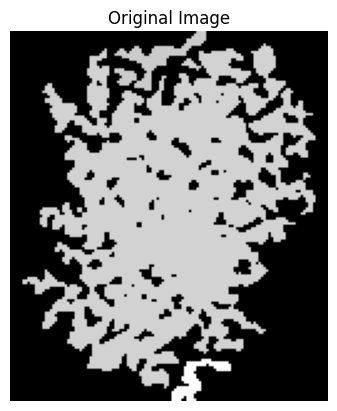

In [8]:
import matplotlib.pyplot as plt

image_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_30_1.tif'  # Update this path
img = io.imread(image_path)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


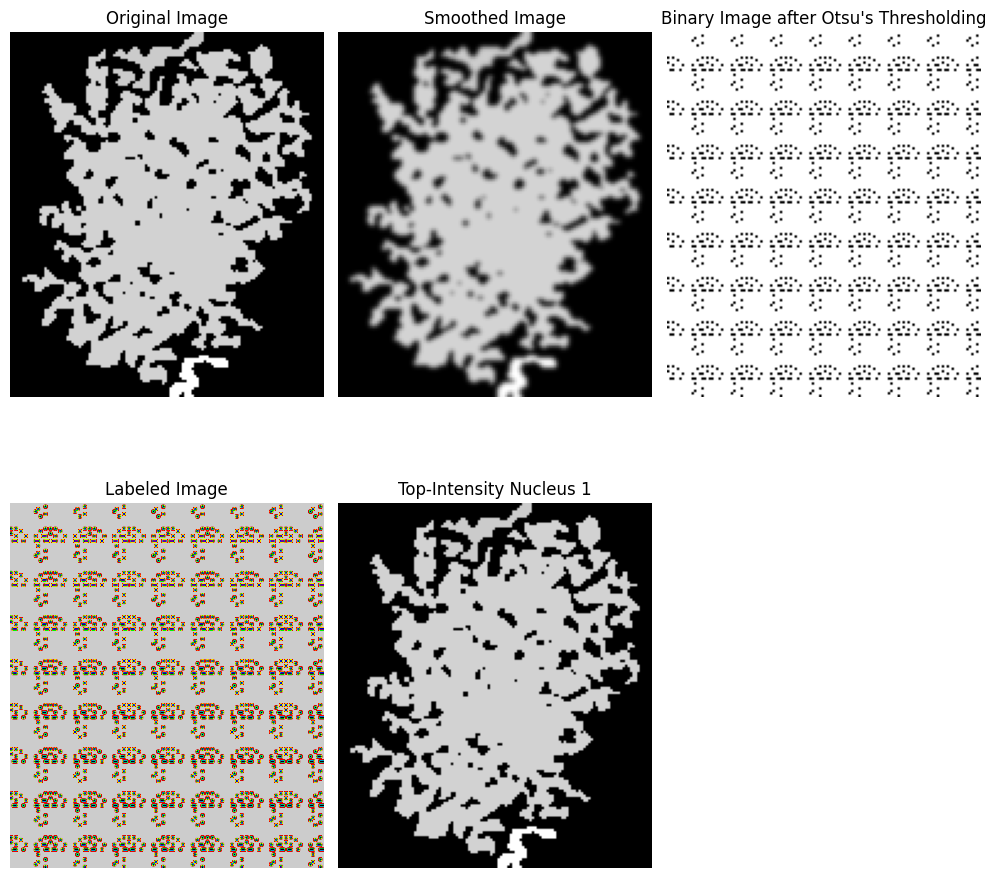

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, morphology, filters, exposure

def visualize_image_processing(image_path, margin=5, min_size=100, top_n=2):
    """
    Visualizes steps in the processing of segmented images, including Gaussian smoothing,
    Otsu's adaptive thresholding, removal of small objects, and displaying top-intensity nuclei.
    """
    img = io.imread(image_path)

    # Display original image
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Apply Gaussian smoothing to reduce noise
    smoothed_img = filters.gaussian(img, sigma=1)
    plt.subplot(2, 3, 2)
    plt.imshow(smoothed_img, cmap='gray')
    plt.title('Smoothed Image')
    plt.axis('off')

    # Apply adaptive thresholding with Otsu's method
    img_eq = exposure.equalize_adapthist(smoothed_img)
    threshold = filters.threshold_otsu(img_eq)
    binary_img = img_eq > threshold
    plt.subplot(2, 3, 3)
    plt.imshow(binary_img, cmap='gray')
    plt.title('Binary Image after Otsu\'s Thresholding')
    plt.axis('off')

    # Label the image to identify distinct nuclei
    labeled_img = measure.label(binary_img)
    plt.subplot(2, 3, 4)
    plt.imshow(labeled_img, cmap='nipy_spectral')
    plt.title('Labeled Image')
    plt.axis('off')

    # Remove small objects
    cleaned_img = morphology.remove_small_objects(labeled_img, min_size=min_size)

    regions = measure.regionprops(cleaned_img, intensity_image=img)
    nuclei_intensity = [(region, region.mean_intensity) for region in regions]

    # Sort nuclei based on intensity, descending
    nuclei_intensity.sort(key=lambda x: x[1], reverse=True)
    top_nuclei = nuclei_intensity[:top_n]

    # Display top-intensity nuclei
    for i, (region, intensity) in enumerate(top_nuclei, start=1):
        minr, minc, maxr, maxc = region.bbox
        minr = max(minr - margin, 0)
        minc = max(minc - margin, 0)
        maxr = min(maxr + margin, img.shape[0])
        maxc = min(maxc + margin, img.shape[1])

        cropped = img[minr:maxr, minc:maxc]
        plt.subplot(2, 3, 4 + i)
        plt.imshow(cropped, cmap='gray')
        plt.title(f'Top-Intensity Nucleus {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_30_1.tif'  # Update this path
visualize_image_processing(image_path, top_n=2)


### Extracting the Outer Ring of a Patch

In [2]:
image_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_30_1.tif'

In [3]:
from PIL import Image
import numpy as np

def extract_first_square_ring(patch):
    # Extract the outer ring of pixels from a 2D patch
    top_row = patch[0, :]
    bottom_row = patch[-1, :]
    left_column = patch[:, 0]
    right_column = patch[:, -1]

    # Combine top, right, bottom (reversed), and left (reversed) excluding corners to avoid duplication
    outer_ring = np.concatenate([top_row, right_column[1:-1], bottom_row[::-1][1:], left_column[::-1][1:-1]])
    return outer_ring

# Assuming we directly use the uploaded TIFF image
image_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_30_1.tif'  # Replace with the actual path to your TIFF image
image = Image.open(image_path)
image_array = np.array(image)

# Define a patch size and the starting position of the patch
patch_size = 5  # Example: 5x5 pixels
patch_start = (100, 100)  # Example: starting position, adjust as needed

# Define a patch from the image
if len(image_array.shape) == 2:  # For a 2D grayscale image
    patch = image_array[patch_start[0]:patch_start[0]+patch_size, patch_start[1]:patch_start[1]+patch_size]
else:
    raise ValueError("Image is not 2D as expected.")

# Extract the pixel values from the first square ring of the patch
first_square_ring = extract_first_square_ring(patch)

print("First square ring pixel values:", first_square_ring)


First square ring pixel values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
from PIL import Image
import numpy as np

def extract_first_square_ring(patch):
    # Assuming patch is a 2D numpy array
    outer_ring_pixels = np.concatenate([
        patch[0, :],           # Top row
        patch[:, -1][1:-1],    # Right column (excluding the first and last pixel)
        patch[-1, :-1][::-1],  # Bottom row (reversed)
        patch[:, 0][1:-1][::-1]  # Left column (reversed, excluding the first and last pixel)
    ])
    return outer_ring_pixels

# Adjust the image_path to the actual path of your uploaded TIF image
image_path = '/content/drive/My Drive/ExtractionResults/157/cropped_images/top_intensity_nucleus_30_1.tif'  # Update this path to your actual TIF file
image = Image.open(image_path)
image_array = np.array(image)

# Define the patch size and the starting point for the patch
patch_size = 5  # Example patch size
patch_start = (100, 100)  # Example starting point, adjust based on your image

# Extract a 5x5 patch based on the starting point
patch = image_array[patch_start[0]:patch_start[0]+patch_size, patch_start[1]:patch_start[1]+patch_size]

# Extract the first square ring pixel values
first_square_ring = extract_first_square_ring(patch)

print("First square ring pixel values:", first_square_ring)


First square ring pixel values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Testing for the new patch and its location within the image

Found a varied patch starting at: (0, 67)


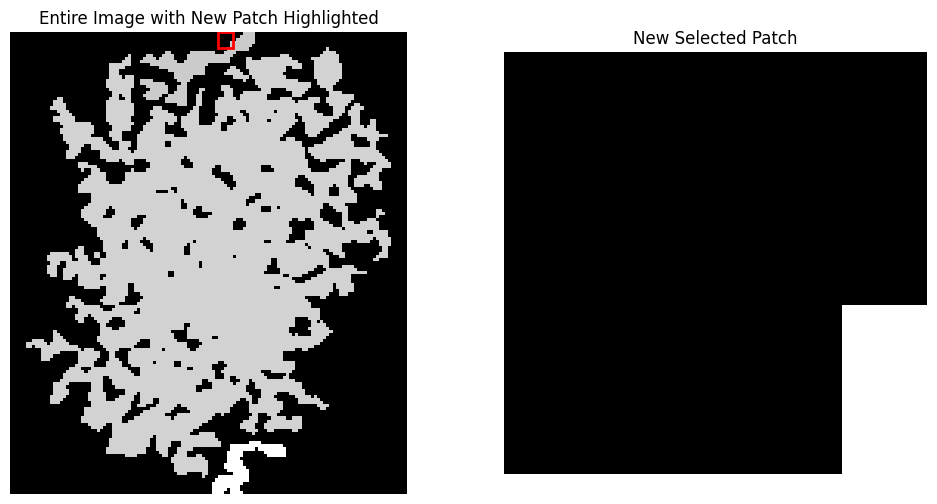

In [8]:
def find_varied_patch(image, patch_size=5, std_threshold=0.1):
    """
    Find a patch with a standard deviation of pixel values above a specified threshold.

    Parameters:
    - image: numpy array of the image.
    - patch_size: size of the square patch.
    - std_threshold: minimum standard deviation to look for.

    Returns:
    - Tuple of (patch, top-left corner of the patch) if found, else None.
    """
    rows, cols = image.shape
    for i in range(rows - patch_size + 1):
        for j in range(cols - patch_size + 1):
            patch = image[i:i+patch_size, j:j+patch_size]
            if np.std(patch) > std_threshold:
                return (patch, (i, j))
    return None, None

# Use the find_varied_patch function to find a new patch
new_patch, new_patch_start = find_varied_patch(image_array, patch_size=5, std_threshold=0.1)

if new_patch is not None:
    print("Found a varied patch starting at:", new_patch_start)
    # Visualize the new patch and its location within the image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_array, cmap='gray')
    ax[0].set_title('Entire Image with New Patch Highlighted')
    ax[0].add_patch(plt.Rectangle((new_patch_start[1]-0.5, new_patch_start[0]-0.5), 5, 5, edgecolor='red', facecolor="none", linewidth=2))
    ax[0].axis('off')
    ax[1].imshow(new_patch, cmap='gray')
    ax[1].set_title('New Selected Patch')
    ax[1].axis('off')
    plt.show()
else:
    print("Could not find a varied patch with the specified criteria.")


### Pixel values and differences are extracted in five different patterns

In [9]:
import numpy as np

def compute_square_features(patch):
    # The outer square will be all the edge pixels of the patch
    # The inner square will be the 3x3 center of the patch
    outer_square = np.array([patch[0, :], patch[:, -1], patch[-1, :], patch[:, 0]])
    inner_square = patch[1:-1, 1:-1]
    return np.concatenate((outer_square.flatten(), inner_square.flatten()))

def compute_circular_features(patch):
    # Approximating a circle in a discrete grid by selecting the middle pixel and its immediate neighbors
    circle_mask = np.array([
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0]
    ], dtype=bool)
    return patch[circle_mask]

def compute_radial_diff_features(patch):
    # Calculate differences in pixel values radially from the center
    center_pixel = patch[2, 2]
    radial_diff = patch - center_pixel
    return radial_diff.flatten()

def compute_angular_diff_features(patch):
    # Calculate differences in pixel values along angular lines from the center
    center_pixel = patch[2, 2]
    # Simplification: we compare the center to the middle pixels of the edges
    angular_diff = np.array([
        patch[0, 2] - center_pixel, patch[1, 2] - center_pixel,
        patch[2, 3] - center_pixel, patch[2, 4] - center_pixel,
        patch[3, 2] - center_pixel, patch[4, 2] - center_pixel,
        patch[2, 1] - center_pixel, patch[2, 0] - center_pixel
    ])
    return angular_diff

# Assuming 'patch' is already defined as a 5x5 numpy array from the image
patch = np.array([
    [0, 1, 1, 1, 0],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1],
    [0, 1, 1, 1, 0]
])

# Compute the descriptors
xGlob = patch.flatten()
xSqr = compute_square_features(patch)
xCirc = compute_circular_features(patch)
deltaRad = compute_radial_diff_features(patch)
deltaAng = compute_angular_diff_features(patch)

# Display the computed features
print("Global Descriptor (xGlob):", xGlob)
print("Square Descriptor (xSqr):", xSqr)
print("Circular Descriptor (xCirc):", xCirc)
print("Radial Differences (deltaRad):", deltaRad)
print("Angular Differences (deltaAng):", deltaAng)


Global Descriptor (xGlob): [0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0]
Square Descriptor (xSqr): [0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0]
Circular Descriptor (xCirc): [1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1]
Radial Differences (deltaRad): [0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0]
Angular Differences (deltaAng): [1 1 1 1 1 1 1 1]


Global Descriptor (xGlob): This includes all pixel values within the patch, which should be a total of 25 values for a 5x5 patch.
Square Descriptor (xSqr): This includes pixel values from the concentric square rings. The values are concatenated, starting from the outer ring to the inner square.
Circular Descriptor (xCirc): This consists of pixel values that are approximated to form a circular pattern within the 5x5 patch.
Radial Differences (deltaRad): This includes the difference in pixel values when compared radially from the center pixel of the patch. It highlights the contrast between the center and other pixels.
Angular Differences (deltaAng): This is a set of differences in pixel values along the angular lines from the center. The output indicates that we are only looking at the immediate neighbors diagonally and axially from the center, which simplifies the computation.
These feature vectors represent different aspects of the local texture and structure of the image within the patch, and they can be used for various image processing tasks, such as texture analysis, pattern recognition, and image classification.

### Random_projection

In [10]:
from numpy.random import randn

def random_projection(features, num_components):
    # Create a random matrix with shape (num_features, num_components)
    # The random values are drawn from a Gaussian distribution (mean 0, variance 1)
    random_matrix = randn(features.shape[1], num_components)
    # Project the original features onto the random components
    projected_features = np.dot(features, random_matrix)
    return projected_features

# Stacking all feature vectors horizontally
all_features = np.hstack((xGlob.reshape(1, -1), xSqr.reshape(1, -1),
                          xCirc.reshape(1, -1), deltaRad.reshape(1, -1),
                          deltaAng.reshape(1, -1)))

# Apply random projection to reduce the feature vectors to, for example, 10 components
projected_features = random_projection(all_features, num_components=10)

print("Projected Features:", projected_features)


Projected Features: [[ -3.1204922   -8.78179581  11.40609277   2.16660425  -2.9686674
  -12.79798057  12.56150359  -0.22055354   5.58515498 -15.39033672]]


Random_projection for SRP

In [19]:
import numpy as np

def create_random_projection_matrix(rows, cols):
    # RP matrix with elements +1 or -1 with equal probability
    return np.random.choice([1, -1], size=(rows, cols))

def apply_random_projection(features, rp_matrix):
    # Apply the random projection matrix to the features
    return np.dot(rp_matrix, features)

# Define the dimensions of the Random Projection matrix
# According to the given instructions, let's say 'a' is 10 for 'n' = 2, and it increases by 10 for each increment in 'n'
# Adjust 'n' based on your specific patch size and the details provided
n = 2  # For example, for a 5x5 patch
a = 10 + (n - 2) * 10  # 'a' is the number of rows in the RP matrix

# Assuming all_features contains the feature vector from your previous calculations
# and is already sorted if necessary, as per the provided instructions
all_features = np.hstack((xGlob, xSqr, xCirc, deltaRad, deltaAng))

# Create the RP matrix
rp_matrix = create_random_projection_matrix(a, all_features.shape[0])

# Apply the RP matrix to transform the features
projected_features = apply_random_projection(all_features, rp_matrix)

print("Projected Features:", projected_features)



Projected Features: [ 57  99  77 -37  47 -53 -13 -13  21 -73]


### Final SRP Feature Descriptor

In [17]:
import numpy as np

# Assuming xGlob, xSqr, xCirc, deltaRad, deltaAng are your initial feature vectors
# For demonstration, let's create dummy data for these vectors
# Replace these with your actual extracted feature vectors
xGlob = np.random.randint(-10, 10, 25)  # Global features from a 5x5 patch
xSqr = np.random.randint(-10, 10, 20)   # Features from square patterns
xCirc = np.random.randint(-10, 10, 15)  # Features from circular patterns
deltaRad = np.random.randint(-10, 10, 20)  # Radial differences
deltaAng = np.random.randint(-10, 10, 20)  # Angular differences

def create_random_projection_matrix(rows, cols):
    """Create a RP matrix with elements +1 or -1 with equal probability."""
    return np.random.choice([1, -1], size=(rows, cols))

def apply_random_projection(feature_vector, rp_matrix):
    """Apply the random projection matrix to a feature vector."""
    return np.dot(rp_matrix, feature_vector)

# Define the number of dimensions for the transformed space
num_components = 10  # For example, reduce each feature set to 10 dimensions

# Apply RP to each feature set individually
rp_matrix_fG = create_random_projection_matrix(num_components, xGlob.size)
projected_fG = apply_random_projection(xGlob, rp_matrix_fG)

rp_matrix_fS = create_random_projection_matrix(num_components, xSqr.size)
projected_fS = apply_random_projection(xSqr, rp_matrix_fS)

rp_matrix_fC = create_random_projection_matrix(num_components, xCirc.size)
projected_fC = apply_random_projection(xCirc, rp_matrix_fC)

rp_matrix_fR = create_random_projection_matrix(num_components, deltaRad.size)
projected_fR = apply_random_projection(deltaRad, rp_matrix_fR)

rp_matrix_fA = create_random_projection_matrix(num_components, deltaAng.size)
projected_fA = apply_random_projection(deltaAng, rp_matrix_fA)

# Horizontally concatenate these projected feature vectors
final_srp_descriptor = np.hstack((projected_fG, projected_fS, projected_fC, projected_fR, projected_fA))

print("Final SRP Feature Descriptor:", final_srp_descriptor)


Final SRP Feature Descriptor: [-30 -10 -16  20 -64 -10  24 -14   6  54 -57 -21  15  13  17  15  11  21
  39  15  17  17  25  -9   9 -21 -17  -1 -11 -29   6 -40 -12  18 -16  68
  20 -20 -20 -52  13   7 -17   9  25   7  -3  -3 -43  21]
